In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parulpandey/palmer-archipelago-antarctica-penguin-data")

print("Path to dataset files:", path)

Path to dataset files: /home/ikx/.cache/kagglehub/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data/versions/1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from tabulate import tabulate
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from itertools import combinations
import statsmodels.api as sm

In [34]:
df = pd.read_csv(path + '/penguins_size.csv')

In [35]:
def dataframe_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """
    Выполняет очистку датасета от пропусков и некорректных значений.
    """
    df = df.dropna()
    df = df[df['sex'] != '.']
    return df

def dataset_report(df: pd.DataFrame, top_n: int = None):
    """
    Генерация сводной таблицы по датафрейму:
    - для числовых признаков: min, max, mean
    - для категориальных признаков: распределение (все или top_n значений)
    
    :param df: DataFrame для анализа
    :param top_n: ограничение на количество выводимых значений (например, top_n=5)
    """
    info = []
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            info.append([
                col,
                str(df[col].dtype),
                df[col].isna().sum(),
                round(df[col].isna().mean()*100, 2),
                df[col].nunique(),
                df[col].min(),
                df[col].max(),
                round(df[col].mean(), 2) if df[col].notna().any() else "-",
                "-"
            ])
        else:
            # распределение категориального признака
            vc = df[col].value_counts(dropna=False)
            if top_n is not None and len(vc) > top_n:
                top = vc.head(top_n)
                other_sum = vc.iloc[top_n:].sum()
                dist = dict(top)
                dist["Other"] = other_sum
            else:
                dist = dict(vc)
            dist_str = ", ".join([f"{k}: {v}" for k, v in dist.items()])
            info.append([
                col,
                str(df[col].dtype),
                df[col].isna().sum(),
                round(df[col].isna().mean()*100, 2),
                df[col].nunique(),
                "-",
                "-",
                "-",
                dist_str
            ])
    
    headers = [
        "Колонка", "Тип", "Пропуски", "% пропусков",
        "Уникальные", "Мин", "Макс", "Среднее", "Распределение"
    ]
    
    print("Размер датасета:", df.shape)
    print(tabulate(info, headers=headers, tablefmt="grid"))


def correlation_table(df, features):
    """
    Вычисляет коэффициенты корреляции Пирсона и Спирмена для всех пар числовых признаков
    и выводит таблицу через tabulate.
    
    Параметры:
    -----------
    df : DataFrame
        Таблица с данными
    features : list[str]
        Список числовых признаков
    """
    
    results = []

    for f1, f2 in combinations(features, 2):
        subset = df[[f1, f2]].dropna()
        x, y = subset[f1], subset[f2]

        # Пирсон
        r_p, p_p = pearsonr(x, y)
        # Спирмен
        r_s, p_s = spearmanr(x, y)

        results.append([
            f1,
            f2,
            round(r_p, 3),
            round(p_p, 5),
            round(r_s, 3),
            round(p_s, 5)
        ])

    # Таблица DataFrame
    corr_table = pd.DataFrame(results, columns=[
        "Признак 1", "Признак 2", "Пирсон r", "p-value (Пирсон)", "Спирмен ρ", "p-value (Спирмен)"
    ])

    # Вывод через tabulate
    print(tabulate(corr_table, headers='keys', tablefmt='grid', showindex=False))

    # return corr_table



In [36]:
def plot_pairwise(df, features, target, diag="hist"):
    """
    Визуализация по всем парам количественных признаков.
    
    Параметры:
    -----------
    df : DataFrame
        Таблица с данными
    features : list[str]
        Список количественных признаков для анализа
    target : str
        Категориальная переменная (классы, например species)
    diag : {"hist", "kde"}, default="hist"
        Что рисовать на диагонали: гистограмму или плотность
    """
    
    # доступные маркеры
    marker_styles = ["o", "s", "D", "^", "v", "X", "P", "*", "H", "<", ">"]
    
    # количество классов
    n_classes = df[target].nunique()
    
    # берём столько форм, сколько нужно
    markers = marker_styles[:n_classes]
    
    sns.pairplot(
        df[features + [target]],
        hue=target,                      # цвет по классам
        diag_kind=diag,                  # диагональ: hist или kde
        markers=markers,                 # адаптивный выбор форм
        diag_kws={"bins": 20, "edgecolor": "k"} if diag=="hist" else {},
        plot_kws={"alpha": 0.7, "s": 40}  # прозрачность и размер точек
    )
    
    plt.show()

def heatmap_corr(df_sub, features, title="Корреляционные матрицы"):
    """
    Строит 2 тепловые карты корреляций (Пирсон и Спирман) рядом.
    
    Параметры:
    -----------
    df_sub : DataFrame
        Датасет
    features : list[str]
        Список количественных признаков
    title : str
        Заголовок для всей фигуры
    """
    corr_pearson = df_sub[features].corr(method="pearson")
    corr_spearman = df_sub[features].corr(method="spearman")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm",
                vmin=-1, vmax=1, ax=axes[0])
    axes[0].set_title("Корреляция (Пирсон)")

    sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap="coolwarm",
                vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title("Корреляция (Спирман)")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def pairplot_with_regression(df, class_col, features):
    """
    Строит сетку графиков (аналог sns.pairplot) для всех пар признаков.
    В непарных клетках - scatter + регрессия + 95% PI.
    На диагонали - гистограммы.
    """

    n = len(features)
    classes = df[class_col].dropna().unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

    fig, axes = plt.subplots(n, n, figsize=(4*n, 4*n))

    for i, f1 in enumerate(features):
        for j, f2 in enumerate(features):

            ax = axes[i, j]

            # Диагональ: гистограмма
            if i == j:
                for c, col in zip(classes, colors):
                    subset = df[df[class_col] == c][f1].dropna()
                    ax.hist(subset, bins=20, alpha=0.5, color=col, label=c)
                ax.set_xlabel(f1)
                ax.set_ylabel("Частота")

            else:
                # Scatterplot с разными классами
                for c, col in zip(classes, colors):
                    subset = df[df[class_col] == c][[f1, f2]].dropna()
                    ax.scatter(subset[f1], subset[f2], alpha=0.6, color=col, label=c)

                # Линия регрессии (по всем данным)
                subset = df[[f1, f2]].dropna()
                if not subset.empty:
                    X = subset[f1]
                    y = subset[f2]
                    X_const = sm.add_constant(X)
                    model = sm.OLS(y, X_const).fit()

                    # Предсказания
                    x_pred = np.linspace(X.min(), X.max(), 200)
                    X_pred_const = sm.add_constant(x_pred)
                    pred = model.get_prediction(X_pred_const)
                    pred_summary = pred.summary_frame(alpha=0.05)

                    # Линия регрессии
                    ax.plot(x_pred, pred_summary["mean"], color="red")

                    # Прогнозный интервал
                    ax.fill_between(
                        x_pred,
                        pred_summary["obs_ci_lower"],
                        pred_summary["obs_ci_upper"],
                        color="red",
                        alpha=0.2
                    )

                ax.set_xlabel(f1)
                ax.set_ylabel(f2)

            # Только в первой строке показываем легенду
            if i == 0 and j == n-1:
                ax.legend()

    plt.tight_layout()
    plt.show()

In [37]:
"""
Статистика по исходному датасету
"""
dataset_report(df)

Размер датасета: (344, 7)
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| Колонка           | Тип     |   Пропуски |   % пропусков |   Уникальные | Мин    | Макс   | Среднее   | Распределение                           |
+===================+=========+============+===============+==============+========+========+===========+=========================================+
| species           | object  |          0 |          0    |            3 | -      | -      | -         | Adelie: 152, Gentoo: 124, Chinstrap: 68 |
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| island            | object  |          0 |          0    |            3 | -      | -      | -         | Biscoe: 168, Dream: 124, Torgersen: 52  |
+-------------------+---------+------------+---------------+--------------+--------+--

In [38]:
"""
Статистика по чистому датасету
"""
df = dataframe_cleaning(df)
dataset_report(df)

Размер датасета: (333, 7)
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| Колонка           | Тип     |   Пропуски |   % пропусков |   Уникальные | Мин    | Макс   | Среднее   | Распределение                           |
+===================+=========+============+===============+==============+========+========+===========+=========================================+
| species           | object  |          0 |             0 |            3 | -      | -      | -         | Adelie: 146, Gentoo: 119, Chinstrap: 68 |
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| island            | object  |          0 |             0 |            3 | -      | -      | -         | Biscoe: 163, Dream: 123, Torgersen: 47  |
+-------------------+---------+------------+---------------+--------------+--------+--


Визуализация признаков по классам: species


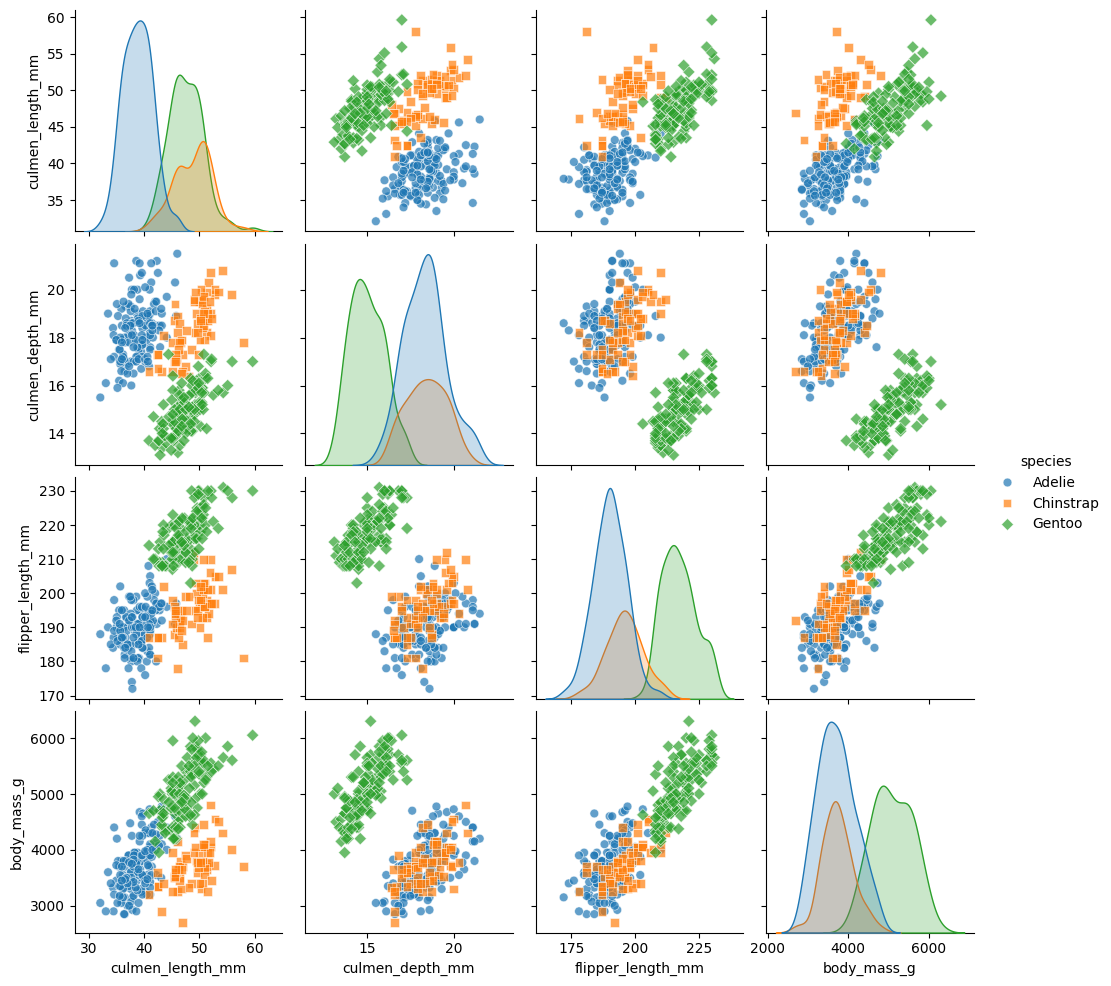


Визуализация признаков по классам: island


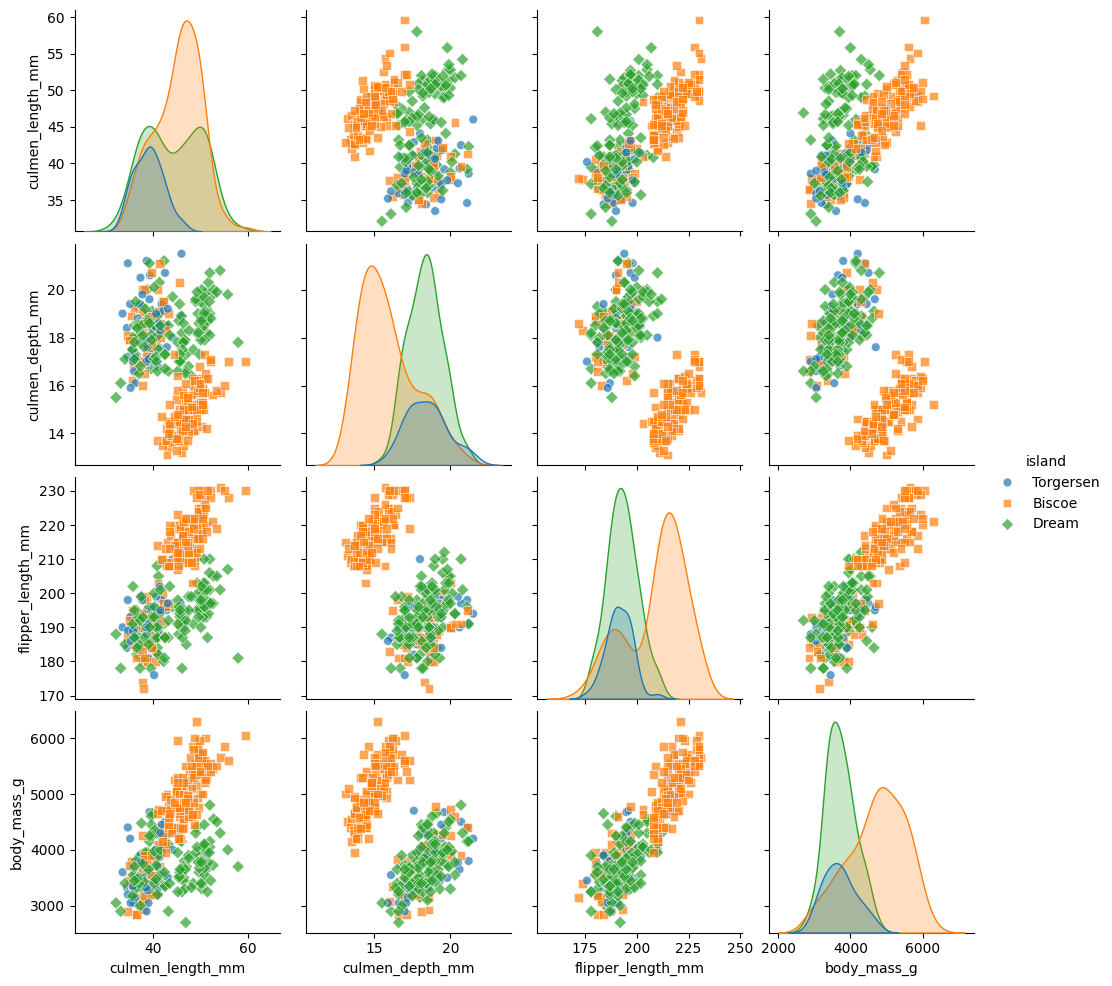


Визуализация признаков по классам: sex


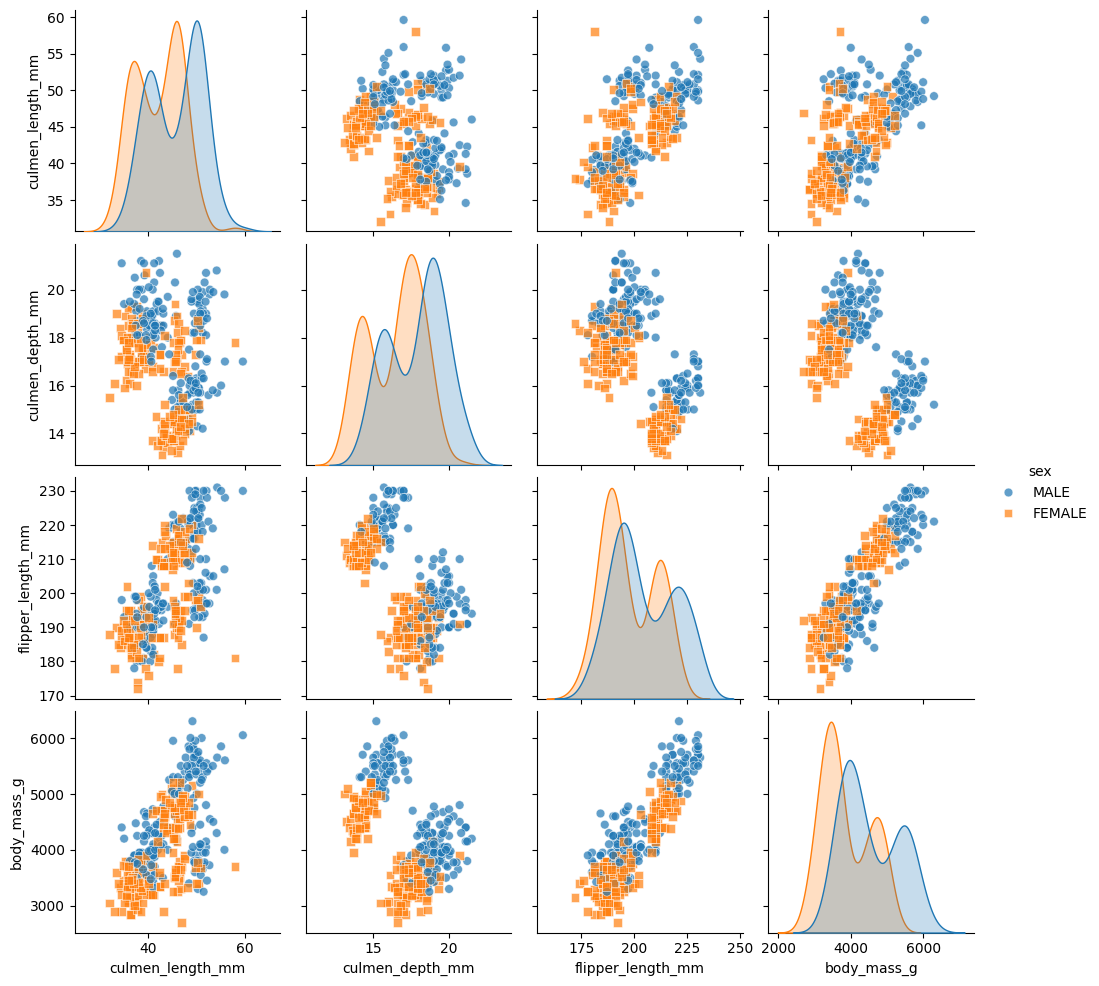

In [39]:
"""
Попарная визуализация количественных признаков для каждого таргета
"""

features = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]
targets = ["species", "island", "sex"]

for target in targets:
    print(f"\nВизуализация признаков по классам: {target}")
    plot_pairwise(df, features, target, diag="kde")


=== Корреляция на всем датасете ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.229 |              3e-05 |      -0.214 |               8e-05 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.653 |              0     |       0.67  |               0     |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.589 |              0     |       0.576 |               0     |
+-------------------+-------------------+------------+--------------

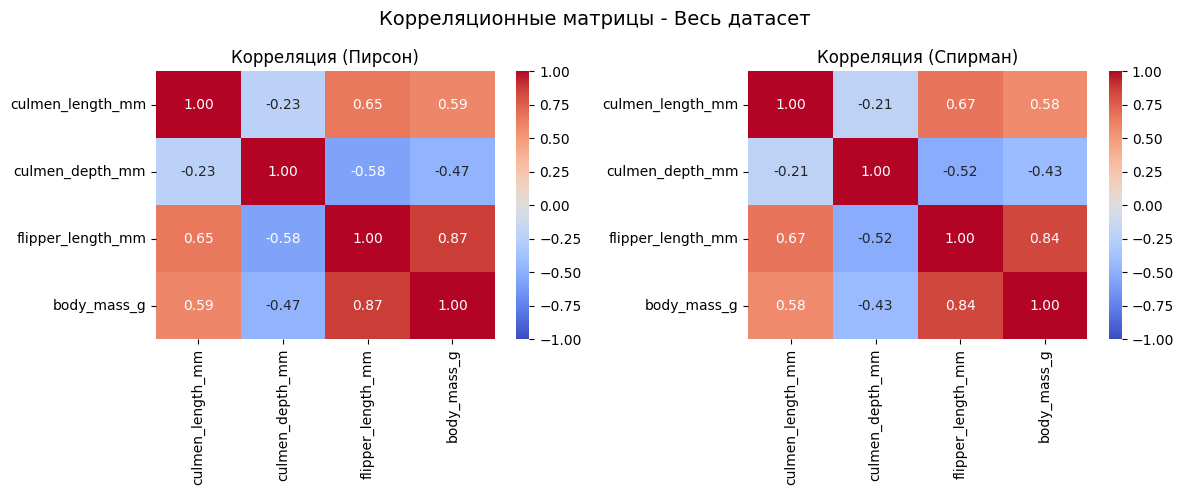

In [40]:
print("=== Корреляция на всем датасете ===")
correlation_table(df, features)
heatmap_corr(df, features, title="Корреляционные матрицы - Весь датасет")



Корреляция по классу: species

=== Корреляция для обьектов: Adelie ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.386 |            0       |       0.355 |               1e-05 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.332 |            4e-05   |       0.348 |               2e-05 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.544 |            0       |       0.544 |               0     |
+-------------------+----------

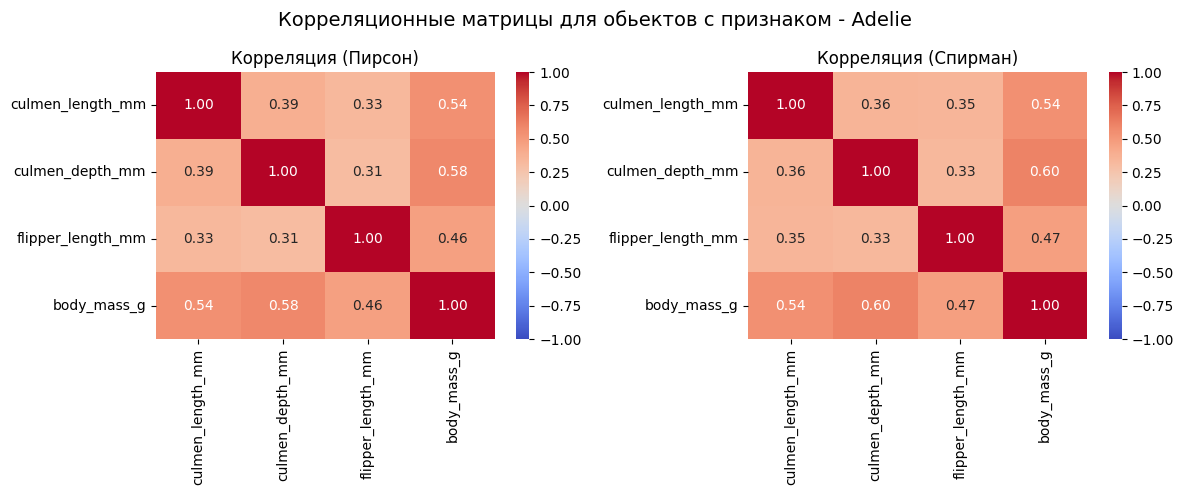


=== Корреляция для обьектов: Chinstrap ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.654 |              0     |       0.672 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.472 |              5e-05 |       0.533 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.514 |              1e-05 |       0.525 |                   0 |
+-------------------+-------------------+------------+------

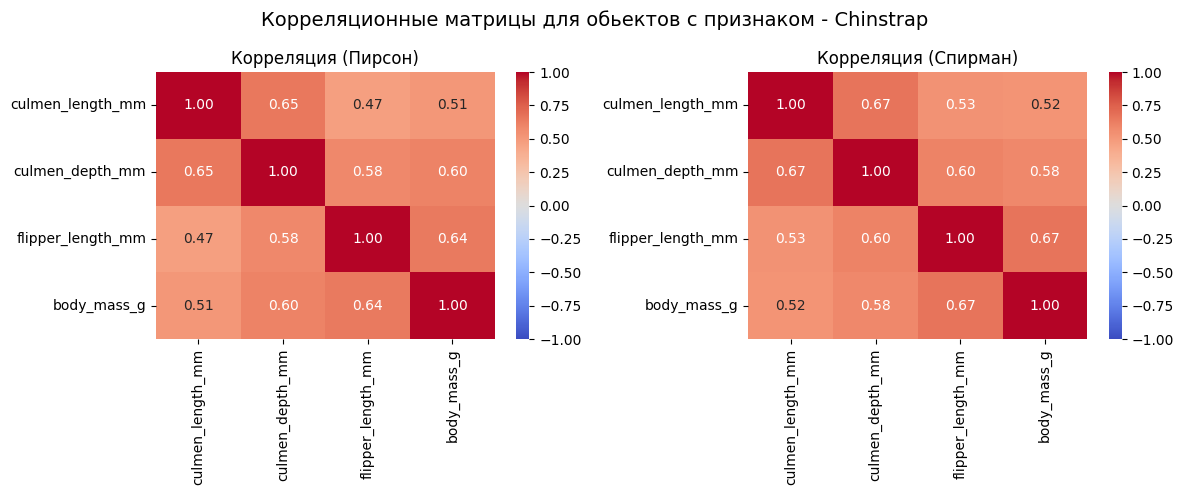


=== Корреляция для обьектов: Gentoo ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.654 |                  0 |       0.652 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.664 |                  0 |       0.659 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.667 |                  0 |       0.684 |                   0 |
+-------------------+-------------------+------------+---------

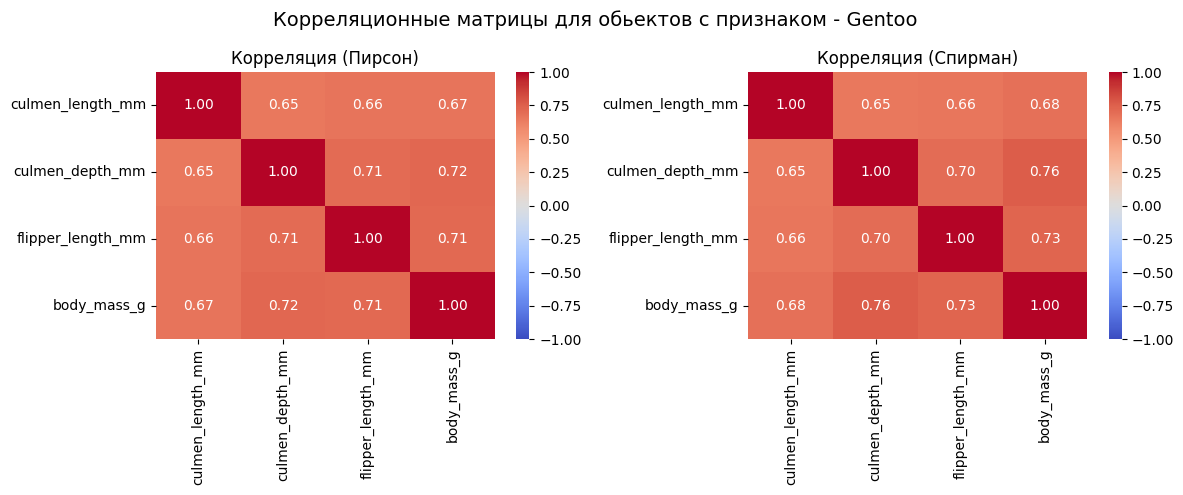



Корреляция по классу: island

=== Корреляция для обьектов: Torgersen ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.216 |            0.14461 |       0.187 |             0.20797 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.41  |            0.00417 |       0.444 |             0.00176 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.426 |            0.0028  |       0.437 |             0.00215 |
+-------------------+--------

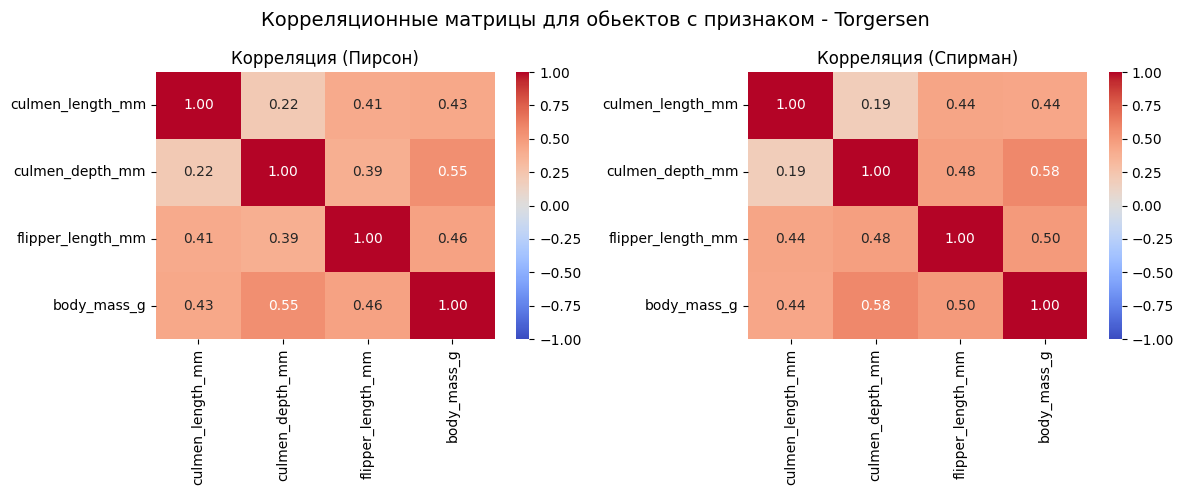


=== Корреляция для обьектов: Biscoe ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.445 |                  0 |      -0.284 |             0.00024 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.868 |                  0 |       0.848 |             0       |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.87  |                  0 |       0.856 |             0       |
+-------------------+-------------------+------------+---------

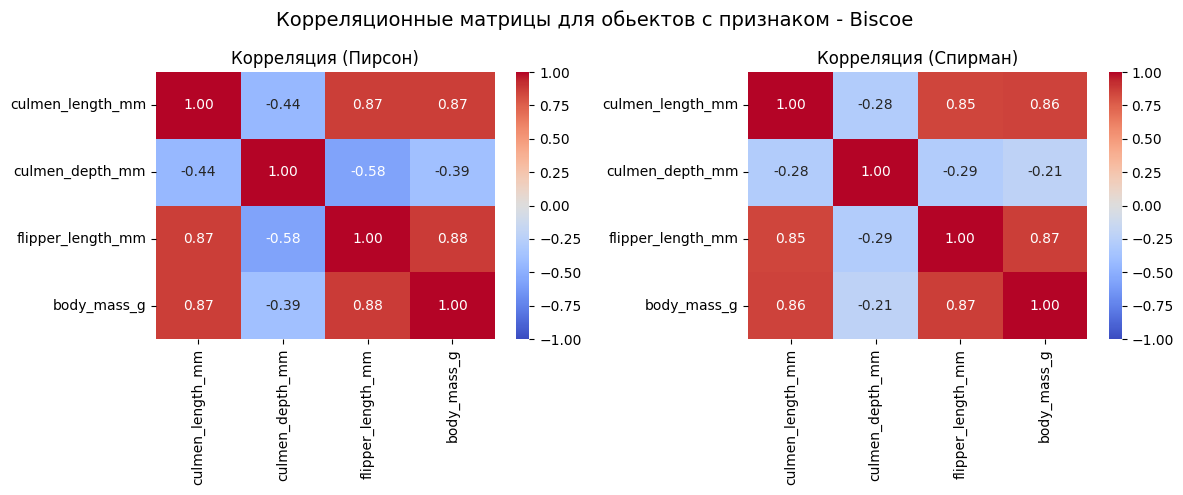


=== Корреляция для обьектов: Dream ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.365 |            3e-05   |       0.38  |             1e-05   |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.526 |            0       |       0.558 |             0       |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.3   |            0.00075 |       0.337 |             0.00014 |
+-------------------+-------------------+------------+----------

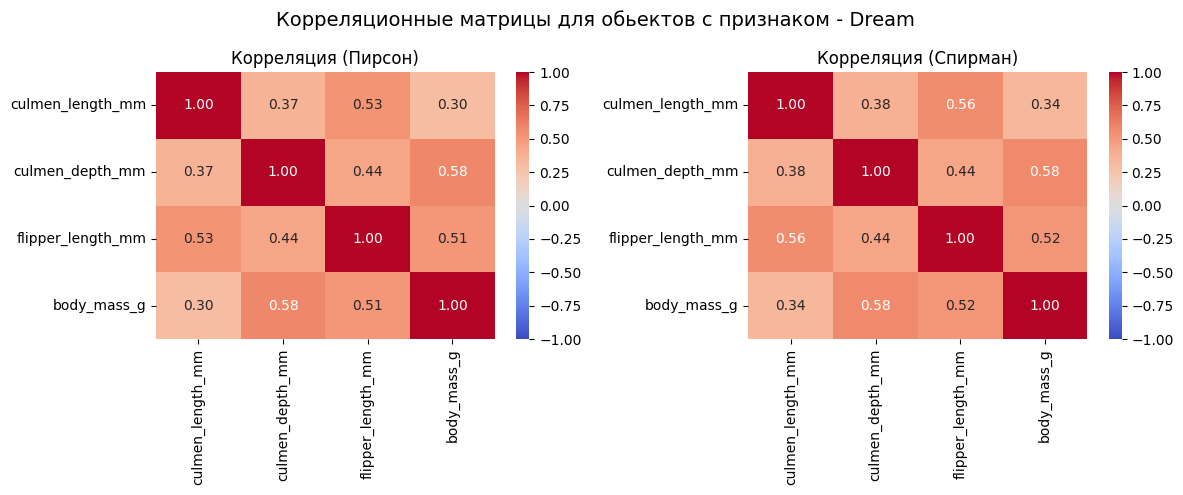



Корреляция по классу: sex

=== Корреляция для обьектов: MALE ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.395 |                  0 |      -0.277 |             0.00027 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.663 |                  0 |       0.641 |             0       |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.477 |                  0 |       0.383 |             0       |
+-------------------+----------------

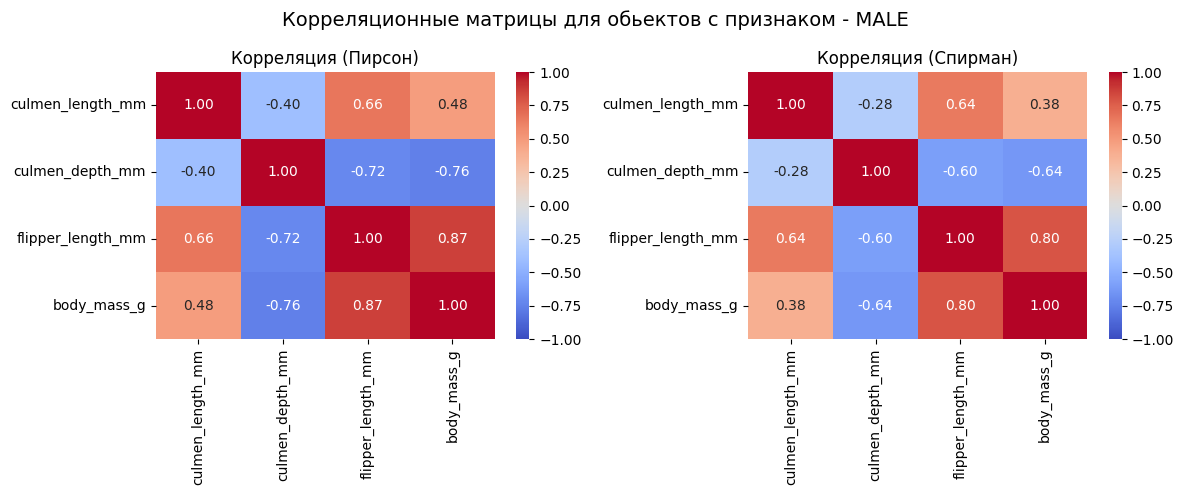


=== Корреляция для обьектов: FEMALE ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| Признак 1         | Признак 2         |   Пирсон r |   p-value (Пирсон) |   Спирмен ρ |   p-value (Спирмен) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.426 |                  0 |      -0.37  |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.571 |                  0 |       0.585 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.581 |                  0 |       0.575 |                   0 |
+-------------------+-------------------+------------+---------

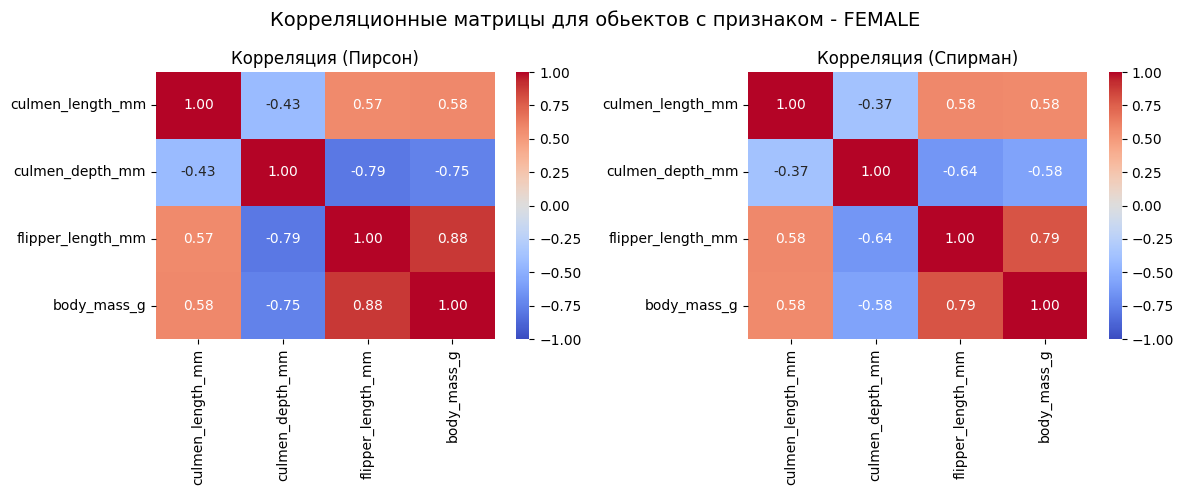

In [ ]:
for target in targets:
    display(Markdown(f"## 🔹 Корреляция по признаку: **{target}**"))

    for cls in df[target].dropna().unique():
        display(Markdown(f"### ▶ Корреляция для объектов: **{cls}**"))
        
        # Таблица корреляций
        correlation_table(df[df[target] == cls], features)
        
        # Тепловая карта
        heatmap_corr(
            df[df[target] == cls],
            features,
            title=f"Корреляционные матрицы для объектов с признаком '{cls}'"
        )

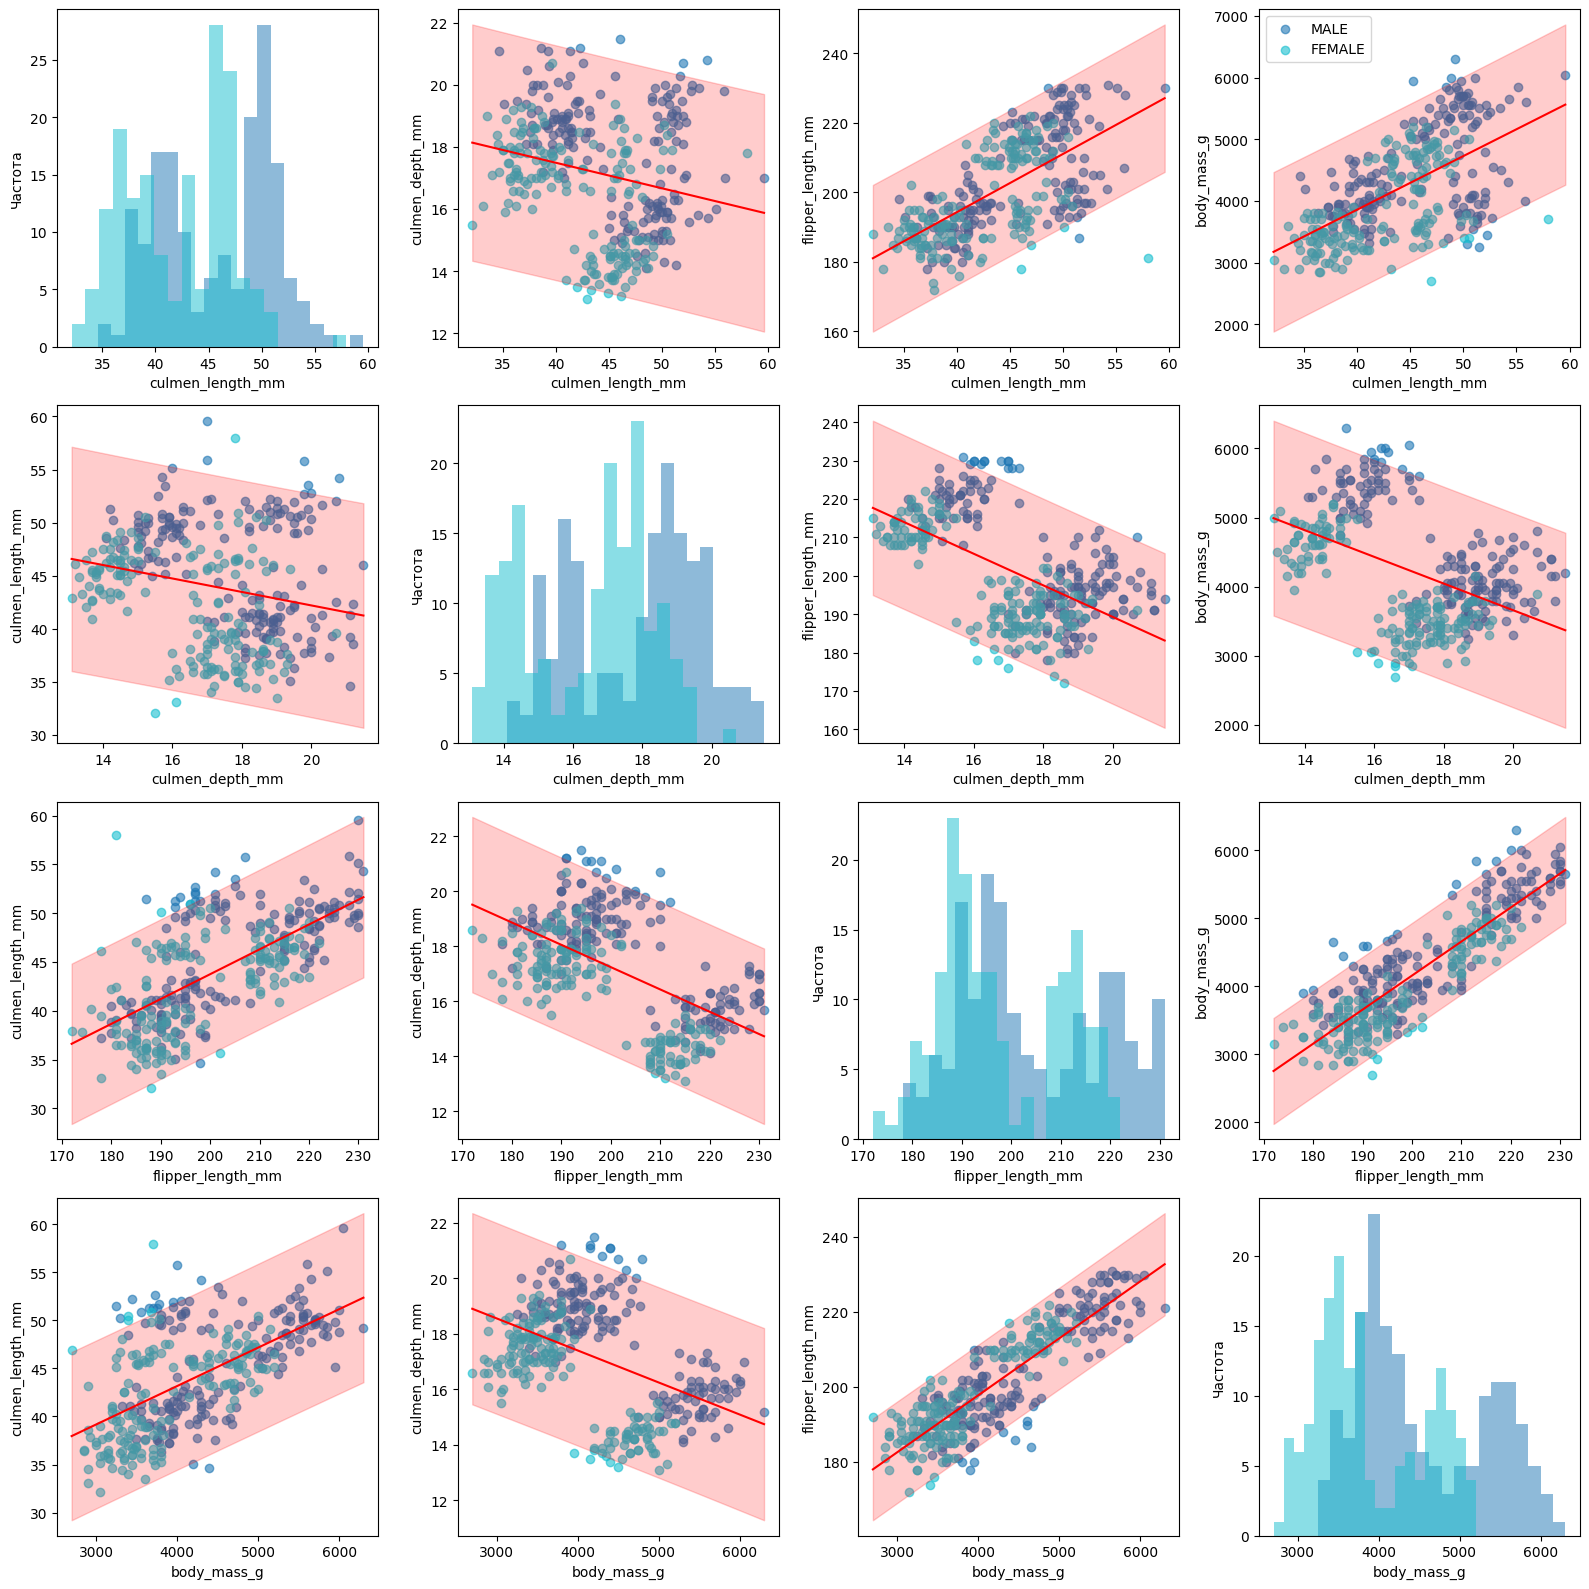

In [ ]:
pairplot_with_regression(df, class_col="sex", features=features)